# Analysis of MH Hybrid Capture Data
Daniel Standage  
2023-11-13

## Overview

In September 2022, NBFAC sequenced four replicates of a NIST reference material (SRM 8398) after enriching with a microhaplotype (MH) probe set designed in-house and synthesized by Twist.
Examination of the sequence data immediately uncovered an acute problem with interlocus balance—a very small number of targets accounted for a substantial plurality of the total reads sequenced in each sample (it was later determined that these targets had repetitive content).
Closer examination also revealed a consistent trend with respect to marker length and *typing success rate*, or the percentage of reads aligned to a marker that span all of its constituent SNPs.
Since these initial observations, NBFAC has had a goal to refine the probe set to exclude problematic loci and focus on markers with reasonable expectation of producing good data; that is, with sufficiently high empirical typing success rates.

At the time it was designed the 416-MH probe set was fairly comprehensive.
Since then, however, the number of published MHs has increased drastically.
Updates to MicroHapDB and Microhapulator were needed not only to handle the increased scale of data, but also to better handle MHs that have multiple alternative published *marker definitions*—different target SNPs (and corresponding allele designations) at the locus.
The most recent updates to these resources finally allowed a re-analysis of the 2022 data that incorporates all marker definitions for each locus—not just the longest or shortest—and excludes some markers based on an *a priori* determination of repetitive content.

The code, figures, and narrative below examines the distribution of marker length and the relationship it has with allelic diversity (effective number of alleles or $A_e$) and typing success rate.
These observations are then used to select an updated set of MH targets for the next round of panel design, making thousands of recently published MHs eligible for inclusion.


## Preamble

The following blocks of code parse the MicroHapulator output to load relevant data for each sample into memory and aggregate the data into a pair of tables to facilitate analysis.
This section is safe to ignore if you're only interested in the results.

In [1]:
import json
from matplotlib import pyplot as plt
import microhapdb
import pandas as pd
from pathlib import Path

In [2]:
microhapdb.__version__

'0.11+10.gba4ce3e'

In [3]:
def aggregate_counts_and_averages():
    counts = pd.concat(map(sample_read_counts, ("SRM8398-1", "SRM8398-2", "SRM8398-3", "SRM8398-4")))
    counts = counts[~counts.RepFlagged]
    counts["TypingRate"] = counts.apply(lambda row: row.TypedReads / row.TotalReads if row.TotalReads > 0 else 0.0, axis=1)
    counts = counts.sort_values(["Marker", "Sample"]).reset_index(drop=True)
    averages = list()
    for markerid, subset in counts.groupby("Marker"):
        avg_type_rate = sum(subset.TypingRate) / len(subset.TypingRate)
        averages.append((markerid, avg_type_rate, subset.Length.iloc[0], subset.Ae.iloc[0]))
    averages = pd.DataFrame(averages, columns=["Marker", "TypingRate", "Length", "Ae"])
    averages["Locus"] = averages.Marker.apply(lambda x: x.split(".")[0])
    averages = averages.sort_values("Ae", ascending=False).reset_index(drop=True)
    return counts, averages

In [4]:
def sample_read_counts(sample_name):
    type_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-type.json"
    repeat_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-repetitive-reads.csv"
    table = parse_typed_read_counts(type_path)
    table = flag_repetitive_markers(table, repeat_path)
    table = incorporate_length_and_ae(table)
    table["Sample"] = sample_name
    return table[["Sample", "TotalReads", "TypedReads", "RepetitiveReads", "RepFlagged", "Length", "Ae"]].reset_index()

In [5]:
def parse_typed_read_counts(typing_counts_path):
    data = list()
    with open(typing_counts_path, "r") as fh:
        result = json.load(fh)
    for marker in result["markers"]:
        typed_reads = sum(result["markers"][marker]["typing_result"].values())
        untyped_reads = result["markers"][marker]["num_discarded_reads"]
        total_reads = typed_reads + untyped_reads
        data.append((marker, total_reads, typed_reads))
    return pd.DataFrame(data, columns=["Marker", "TotalReads", "TypedReads"]).set_index("Marker")

In [6]:
def flag_repetitive_markers(table, repeat_counts_path):
    data = pd.read_csv(repeat_counts_path)
    data["RepFlagged"] = data.Marker.apply(lambda x: x in microhapdb.repeats.index)
    data = data.set_index("Marker")
    return table.join(data, on="Marker")

In [7]:
def incorporate_length_and_ae(table):
    data = microhapdb.markers[["Name", "Extent", "Ae"]].copy().rename(columns={"Name": "Marker", "Extent": "Length"}).set_index("Marker")
    return table.join(data, on="Marker")

In [8]:
counts, averages = aggregate_counts_and_averages()

In [9]:
counts

,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae,TypingRate
0,mh01CP-010,SRM8398-1,2123,1799,0,False,23,2.778,0.847386
1,mh01CP-010,SRM8398-2,2420,2076,0,False,23,2.778,0.857851
2,mh01CP-010,SRM8398-3,1591,1408,4,False,23,2.778,0.884978
3,mh01CP-010,SRM8398-4,2395,1873,0,False,23,2.778,0.782046
4,mh01CP-012,SRM8398-1,3692,3239,0,False,31,3.242,0.877302
...,...,...,...,...,...,...,...,...,...
1519,mh22NH-27,SRM8398-4,3643,2672,0,False,82,3.339,0.733461
1520,mh22USC-22qA,SRM8398-1,1857,1336,0,False,64,4.166,0.719440
1521,mh22USC-22qA,SRM8398-2,2261,1680,0,False,64,4.166,0.743034
1522,mh22USC-22qA,SRM8398-3,1721,1253,0,False,64,4.166,0.728065


In [10]:
averages

,Marker,TypingRate,Length,Ae,Locus
0,mh03LV-06.v4,0.007925,350,29.268,mh03LV-06
1,mh03LV-06.v5,0.010206,309,26.239,mh03LV-06
2,mh13USC-13qA.v3,0.058634,279,16.675,mh13USC-13qA
3,mh01KK-212.v2,0.060720,243,16.242,mh01KK-212
4,mh01KK-212.v1,0.061197,243,16.198,mh01KK-212
...,...,...,...,...,...
376,mh05KK-078,0.736643,60,1.261,mh05KK-078
377,mh17KK-105.v2,0.520926,85,1.190,mh17KK-105
378,mh17KK-076,0.807302,41,1.186,mh17KK-076
379,mh10KK-084,0.970255,14,1.158,mh10KK-084


In [11]:
len(averages.Locus.unique())

248

> **IMPORTANT NOTE**: markers with repetitive content are excluded from these tables and thus from subsequent analysis.

## Empirical Distribution of Typing Success Rate

The following histogram shows the *typing success rate* for each marker, averaged across four replicates.
Typing rate shows a bimodal distribution.

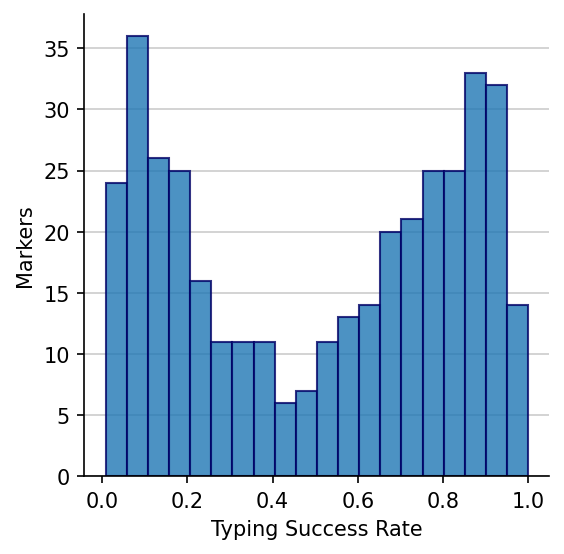

In [12]:
plt.figure(figsize=(4, 4), dpi=150)
plt.hist(averages.TypingRate, bins=20, alpha=0.8, edgecolor="#000066")
plt.xlabel("Typing Success Rate")
plt.ylabel("Markers")
ax = plt.gca()
ax.yaxis.grid(True, color="#CCCCCC")
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.savefig("hybcap-typing-hist.png", dpi=150)

Plotting typing success rate as a function of marker length shows a strong negative correlation.
But plotting allelic diversity (*effective number of alleles* or $A_e$) as a function of marker length shows that the most informative markers are often among the longest.

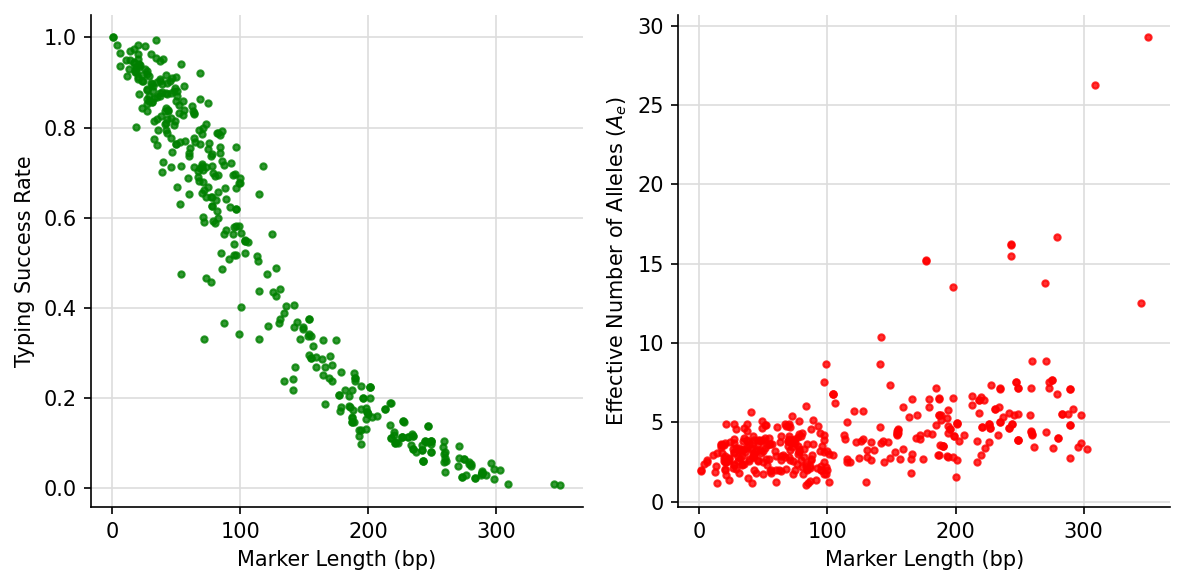

In [13]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.add_subplot(121)
plt.scatter(averages.Length, averages.TypingRate, marker=".", color="green", alpha=0.8)
plt.ylabel("Typing Success Rate")
plt.xlabel("Marker Length (bp)")
ax = plt.gca()
ax.xaxis.grid(True, color="#DDDDDD")
ax.yaxis.grid(True, color="#DDDDDD")
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.add_subplot(122)
plt.scatter(averages.Length, averages.Ae, marker=".", color="red", alpha=0.8)
plt.ylabel("Effective Number of Alleles ($A_e$)")
plt.xlabel("Marker Length (bp)")
ax = plt.gca()
ax.xaxis.grid(True, color="#DDDDDD")
ax.yaxis.grid(True, color="#DDDDDD")
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig("hybcap-length-vs-typing-ae.png", dpi=150)

## Determine Reasonable Length Constraint Given Observed Typing Rates

Using these observations, we need to balance what we see as a reasonable typing success rate with a reasonable minimum bound on $A_e$.
Based on the histogram shown above, a minimum threshold for typing rate was set at 0.4 to include the right mode of the distribution.
For $A_e$, the minimum threshold was set at 3 based on prior experience.
We could explore making the $A_e$ threshold more *exclusive* (stricter, higher), but it's probably not fruitful to explore making it more *inclusive*.

107


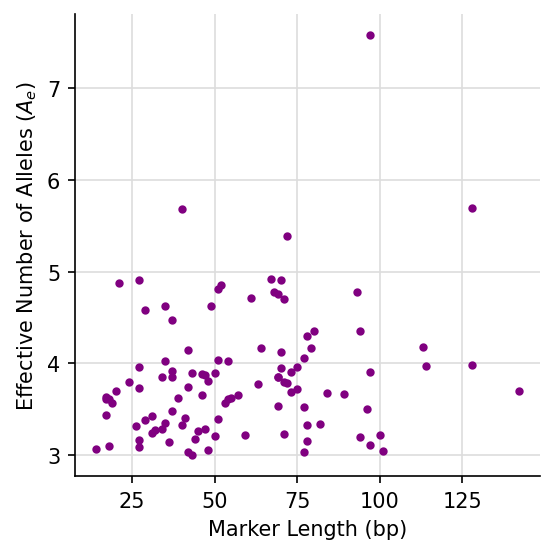

In [14]:
plot_data = averages[(averages.TypingRate > 0.4) & (averages.Ae >= 3)].sort_values("Ae").drop_duplicates("Locus", keep="first")
print(len(plot_data))
plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(plot_data.Length, plot_data.Ae, marker=".", color="purple")
plt.xlabel("Marker Length (bp)")
plt.ylabel("Effective Number of Alleles ($A_e$)")
ax = plt.gca()
ax.xaxis.grid(True, color="#DDDDDD")
ax.yaxis.grid(True, color="#DDDDDD")
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.savefig("hybcap-filter-constraints.png", dpi=150)

Applying those thresholds seems to restrict us to markers that are 120 bp in length or shorter.


## An Updated Target List

Using the thresholds set by examination of empirical distributions, we now go to MicroHapDB and select all marker definitions that satisfy the following criteria:

- less than 150 bp in length (a little buffer in case insert lengths are a bit longer)
- $A_e \geq 3$
- do not contain repetitive DNA

For any locus with multiple marker definitions satisfying these criteria, only the marker with the highest $A_e$ score is retained—all others are discarded.
This gives us 318 MH targets.

In [15]:
max_len_bp = 150
min_ae = 3

In [16]:
panel_ids = [
    m.name for m in microhapdb.Marker.objectify(microhapdb.markers)
    if len(m) < max_len_bp
    and m.data.Ae > min_ae
    and m.name not in microhapdb.repeats.index
]
panel_redund = microhapdb.markers[microhapdb.markers.Name.isin(panel_ids)].copy()
panel_redund["Locus"] = panel_redund.Name.apply(lambda x: x.split(".")[0])
panel = panel_redund.sort_values("Ae", ascending=False).drop_duplicates("Locus", keep="first")
print(len(panel))

390


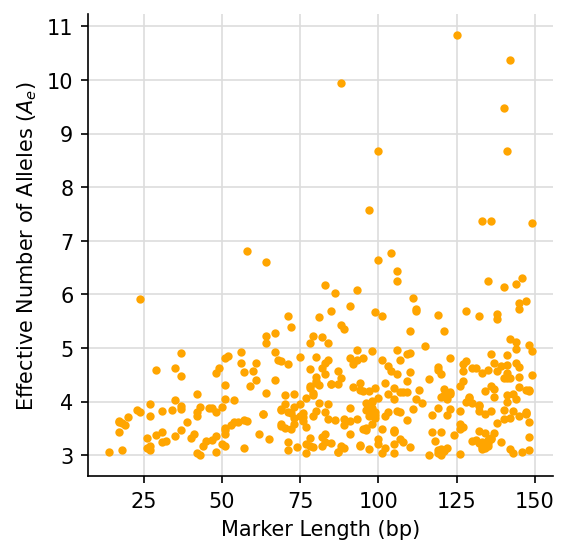

In [17]:
plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(panel.Extent, panel.Ae, marker=".", color="orange")
plt.xlabel("Marker Length (bp)")
plt.ylabel("Effective Number of Alleles ($A_e$)")
ax = plt.gca()
ax.xaxis.grid(True, color="#DDDDDD")
ax.yaxis.grid(True, color="#DDDDDD")
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.savefig("hybcap-updated.png", dpi=150)

In [18]:
panel[panel.Ae > 9][["Name", "NumVars", "Extent", "Ae", "Source"]]

,Name,NumVars,Extent,Ae,Source
2572,mh16WL-038,7,125,10.836,Yu2022G1
2141,mh13USC-13qA.v2,8,142,10.367,Yu2022G1;Yu2022G2
1687,mh10WL-012.v2,6,88,9.940,Yu2022G4
2011,mh12SHY-001.v2,8,140,9.469,Yu2022G1;Yu2022G2;Yu2022G3;Zhu2023
